In [1]:
import numpy as np
import pandas as pd
import torch
import nilearn as nil
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
# import nilearn.plotting
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

## Load the Haxby dataset

In [2]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
# We are fetching the data for subject 4
data_dir = '/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/data'
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# mask the data
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
X = masker.fit_transform(func_file)


behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
y = behavioral['labels']

/ext3/miniconda3/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/ext3/miniconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/home/cl6707/.local/lib/python3.8/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  ret

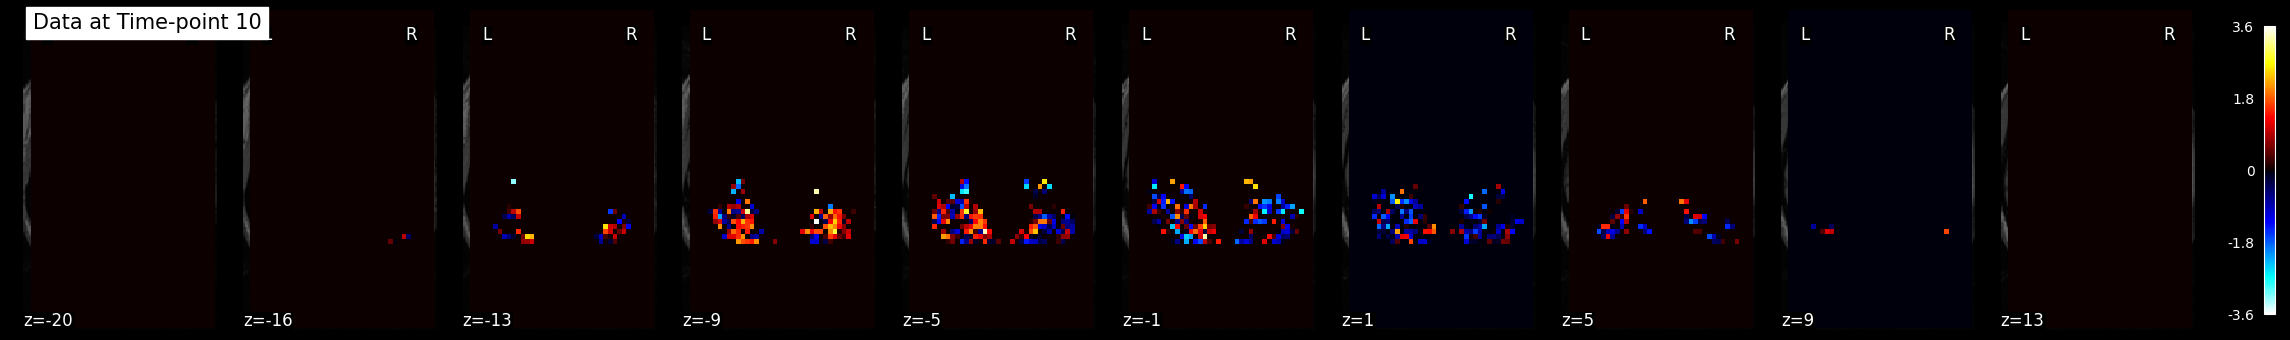

In [29]:
img = masker.inverse_transform(X)

from nilearn.image import index_img

# Get the 10th time-point
single_timepoint_img = index_img(img, 10)

# Plot the single time-point
plotting.plot_stat_map(single_timepoint_img, bg_img=haxby_dataset.anat[0], threshold=None, display_mode='z', cut_coords=10, title="Data at Time-point 10")
plotting.show()


In [25]:
single_timepoint_img

IndexError: Scalar indices disallowed in spatial dimensions; Use `[x]` or `x:x+1`.

In [18]:
haxby_dataset.anat[0]

'/scratch/cl6707/Projects/neuro_interp/Neural_Interpretation/data/haxby2001/subj4/anat.nii.gz'

In [3]:
# creating instance of one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
categories = behavioral['labels'].unique()
enc = OneHotEncoder(categories=[categories], handle_unknown='ignore')
y_onehot = enc.fit_transform(np.array(y).reshape(-1, 1)).toarray()
# turn the sparse matrix into a pandas dataframe
# y = pd.DataFrame(y_onehot.toarray())
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size = 0.2, random_state = 42,shuffle=True) 
bs = 32
dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
dataset_test = torch.utils.data.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))

dataloaders = {'train': torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=1),
                'val': torch.utils.data.DataLoader(dataset_test, batch_size=bs, shuffle=True, num_workers=1)}


In [6]:
sample_batched[0].shape

torch.Size([32, 675])

In [4]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    break

/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f1cf00c6040>
  self.pid = os.fork()


0 torch.Size([32, 675]) torch.Size([32, 9])


## Model Define

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=8):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((6, 6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True), 
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x


## Train the model

In [17]:
# train the model
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time
import copy
num_epochs = 200
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu'):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloaders['val']
            
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(outputs,preds)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1])
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Save loss and accuracy for plotting
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print('Saving best model')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
         time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    # model.load_state_dict(torch.load('best_model.pt'))
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history
 
Model = light_conv_net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
Model.to(device)
Model, val_acc_history, train_acc_history, val_loss_history, train_loss_history = train_model(Model, dataloaders, criterion, optimizer, num_epochs=num_epochs, device=device)   


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9941 Acc: 0.3928


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  0%|          | 1/200 [00:00<02:53,  1.14it/s]

val Loss: 1.9492 Acc: 0.4227
Saving best model

Epoch 1/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9712 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  1%|          | 2/200 [00:01<02:49,  1.17it/s]

val Loss: 1.9492 Acc: 0.4227

Epoch 2/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9705 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  2%|▏         | 3/200 [00:02<02:53,  1.14it/s]

val Loss: 1.9490 Acc: 0.4227

Epoch 3/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9692 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  2%|▏         | 4/200 [00:03<02:51,  1.15it/s]

val Loss: 1.9452 Acc: 0.4227

Epoch 4/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9669 Acc: 0.4005


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  2%|▎         | 5/200 [00:04<02:50,  1.15it/s]

val Loss: 1.9394 Acc: 0.4364
Saving best model

Epoch 5/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9628 Acc: 0.4109


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  3%|▎         | 6/200 [00:05<02:48,  1.15it/s]

val Loss: 1.9300 Acc: 0.4639
Saving best model

Epoch 6/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9590 Acc: 0.4134


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  4%|▎         | 7/200 [00:06<02:47,  1.15it/s]

val Loss: 1.9100 Acc: 0.4639

Epoch 7/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9537 Acc: 0.4160


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  4%|▍         | 8/200 [00:06<02:46,  1.16it/s]

val Loss: 1.9337 Acc: 0.4433

Epoch 8/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9503 Acc: 0.4212


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  4%|▍         | 9/200 [00:07<02:44,  1.16it/s]

val Loss: 1.8930 Acc: 0.4811
Saving best model

Epoch 9/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9384 Acc: 0.4307


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  5%|▌         | 10/200 [00:08<02:42,  1.17it/s]

val Loss: 1.8950 Acc: 0.4742

Epoch 10/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9379 Acc: 0.4341


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  6%|▌         | 11/200 [00:09<02:42,  1.17it/s]

val Loss: 1.9072 Acc: 0.4639

Epoch 11/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9479 Acc: 0.4203


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  6%|▌         | 12/200 [00:10<02:42,  1.16it/s]

val Loss: 1.9149 Acc: 0.4605

Epoch 12/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9347 Acc: 0.4350


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  6%|▋         | 13/200 [00:11<02:40,  1.16it/s]

val Loss: 1.9140 Acc: 0.4605

Epoch 13/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9347 Acc: 0.4324


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  7%|▋         | 14/200 [00:12<02:39,  1.16it/s]

val Loss: 1.8962 Acc: 0.4708

Epoch 14/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9323 Acc: 0.4376


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  8%|▊         | 15/200 [00:12<02:37,  1.17it/s]

val Loss: 1.9032 Acc: 0.4742

Epoch 15/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9253 Acc: 0.4453


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  8%|▊         | 16/200 [00:13<02:37,  1.17it/s]

val Loss: 1.8957 Acc: 0.4742

Epoch 16/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9206 Acc: 0.4479


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  8%|▊         | 17/200 [00:14<02:36,  1.17it/s]

val Loss: 1.9055 Acc: 0.4639

Epoch 17/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9199 Acc: 0.4539


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
  9%|▉         | 18/200 [00:15<02:35,  1.17it/s]

val Loss: 1.8900 Acc: 0.4811

Epoch 18/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9258 Acc: 0.4401


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 10%|▉         | 19/200 [00:16<02:35,  1.17it/s]

val Loss: 1.8889 Acc: 0.4880
Saving best model

Epoch 19/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9156 Acc: 0.4522


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 10%|█         | 20/200 [00:17<02:35,  1.16it/s]

val Loss: 1.8898 Acc: 0.4674

Epoch 20/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9114 Acc: 0.4591


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 10%|█         | 21/200 [00:18<02:33,  1.17it/s]

val Loss: 1.8886 Acc: 0.4742

Epoch 21/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9134 Acc: 0.4522


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 11%|█         | 22/200 [00:18<02:32,  1.17it/s]

val Loss: 1.8847 Acc: 0.4777

Epoch 22/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9057 Acc: 0.4582


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 12%|█▏        | 23/200 [00:19<02:31,  1.17it/s]

val Loss: 1.9342 Acc: 0.4364

Epoch 23/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9205 Acc: 0.4470


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 12%|█▏        | 24/200 [00:20<02:30,  1.17it/s]

val Loss: 1.9033 Acc: 0.4570

Epoch 24/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8989 Acc: 0.4711


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 12%|█▎        | 25/200 [00:21<02:28,  1.18it/s]

val Loss: 1.8881 Acc: 0.4845

Epoch 25/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8945 Acc: 0.4763


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 13%|█▎        | 26/200 [00:22<02:26,  1.18it/s]

val Loss: 1.9284 Acc: 0.4433

Epoch 26/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9039 Acc: 0.4591


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 14%|█▎        | 27/200 [00:23<02:27,  1.17it/s]

val Loss: 1.9201 Acc: 0.4467

Epoch 27/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.9063 Acc: 0.4556


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 14%|█▍        | 28/200 [00:24<02:27,  1.17it/s]

val Loss: 1.8970 Acc: 0.4708

Epoch 28/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8894 Acc: 0.4720


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


val Loss: 1.8824 Acc: 0.4983
Saving best model


 14%|█▍        | 29/200 [00:24<02:27,  1.16it/s]


Epoch 29/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8719 Acc: 0.4961


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 15%|█▌        | 30/200 [00:25<02:25,  1.17it/s]

val Loss: 1.9471 Acc: 0.4124

Epoch 30/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8726 Acc: 0.5013


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 16%|█▌        | 31/200 [00:26<02:23,  1.18it/s]

val Loss: 1.9682 Acc: 0.3883

Epoch 31/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8858 Acc: 0.4806


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 16%|█▌        | 32/200 [00:27<02:22,  1.18it/s]

val Loss: 1.8894 Acc: 0.4811

Epoch 32/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8712 Acc: 0.4961


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 16%|█▋        | 33/200 [00:28<02:23,  1.16it/s]

val Loss: 1.8697 Acc: 0.5017
Saving best model

Epoch 33/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8555 Acc: 0.5116


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 17%|█▋        | 34/200 [00:29<02:22,  1.16it/s]

val Loss: 1.9818 Acc: 0.3677

Epoch 34/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8471 Acc: 0.5202


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 18%|█▊        | 35/200 [00:30<02:21,  1.17it/s]

val Loss: 1.9130 Acc: 0.4399

Epoch 35/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8521 Acc: 0.5220


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 18%|█▊        | 36/200 [00:30<02:19,  1.18it/s]

val Loss: 1.9246 Acc: 0.4467

Epoch 36/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8548 Acc: 0.5134


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 18%|█▊        | 37/200 [00:31<02:17,  1.19it/s]

val Loss: 1.8844 Acc: 0.4708

Epoch 37/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8370 Acc: 0.5357


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 19%|█▉        | 38/200 [00:32<02:16,  1.18it/s]

val Loss: 1.9418 Acc: 0.4227

Epoch 38/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8341 Acc: 0.5340


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 20%|█▉        | 39/200 [00:33<02:20,  1.15it/s]

val Loss: 1.9329 Acc: 0.4261

Epoch 39/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8204 Acc: 0.5504


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 20%|██        | 40/200 [00:34<02:17,  1.16it/s]

val Loss: 1.8744 Acc: 0.4948

Epoch 40/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8024 Acc: 0.5762


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 20%|██        | 41/200 [00:35<02:17,  1.16it/s]

val Loss: 1.9099 Acc: 0.4467

Epoch 41/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8091 Acc: 0.5624


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 21%|██        | 42/200 [00:39<04:39,  1.77s/it]

val Loss: 1.8772 Acc: 0.4948

Epoch 42/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7900 Acc: 0.5900


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 22%|██▏       | 43/200 [00:41<04:55,  1.88s/it]

val Loss: 1.9057 Acc: 0.4536

Epoch 43/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7781 Acc: 0.5978


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 22%|██▏       | 44/200 [00:42<04:42,  1.81s/it]

val Loss: 1.9429 Acc: 0.4296

Epoch 44/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.8051 Acc: 0.5693


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 22%|██▎       | 45/200 [00:44<04:44,  1.83s/it]

val Loss: 1.8906 Acc: 0.4674

Epoch 45/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7924 Acc: 0.5780


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 23%|██▎       | 46/200 [00:48<06:14,  2.43s/it]

val Loss: 1.9040 Acc: 0.4639

Epoch 46/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7724 Acc: 0.5986


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 24%|██▎       | 47/200 [00:50<05:33,  2.18s/it]

val Loss: 1.8758 Acc: 0.4983

Epoch 47/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7413 Acc: 0.6391


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 24%|██▍       | 48/200 [00:51<04:30,  1.78s/it]

val Loss: 1.8970 Acc: 0.4742

Epoch 48/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7489 Acc: 0.6279


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 24%|██▍       | 49/200 [00:51<03:46,  1.50s/it]

val Loss: 1.8950 Acc: 0.4742

Epoch 49/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7213 Acc: 0.6581


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 25%|██▌       | 50/200 [00:53<03:43,  1.49s/it]

val Loss: 1.8830 Acc: 0.4880

Epoch 50/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6994 Acc: 0.6779


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 26%|██▌       | 51/200 [00:54<03:13,  1.30s/it]

val Loss: 1.8889 Acc: 0.4845

Epoch 51/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.7078 Acc: 0.6718


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 26%|██▌       | 52/200 [00:56<03:37,  1.47s/it]

val Loss: 1.9427 Acc: 0.4192

Epoch 52/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6893 Acc: 0.6908


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 26%|██▋       | 53/200 [00:56<03:08,  1.28s/it]

val Loss: 1.8642 Acc: 0.5017

Epoch 53/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6795 Acc: 0.6977


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 27%|██▋       | 54/200 [00:57<02:48,  1.15s/it]

val Loss: 1.8804 Acc: 0.4777

Epoch 54/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6861 Acc: 0.6934


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 28%|██▊       | 55/200 [00:58<02:33,  1.06s/it]

val Loss: 1.9280 Acc: 0.4399

Epoch 55/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6651 Acc: 0.7140


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 28%|██▊       | 56/200 [01:03<05:24,  2.26s/it]

val Loss: 1.8827 Acc: 0.4983

Epoch 56/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6533 Acc: 0.7304


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 28%|██▊       | 57/200 [01:06<05:45,  2.42s/it]

val Loss: 1.8752 Acc: 0.4983

Epoch 57/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6444 Acc: 0.7330


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 29%|██▉       | 58/200 [01:08<05:10,  2.19s/it]

val Loss: 2.0176 Acc: 0.3333

Epoch 58/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6424 Acc: 0.7416


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 30%|██▉       | 59/200 [01:09<04:30,  1.92s/it]

val Loss: 1.8814 Acc: 0.4880

Epoch 59/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6497 Acc: 0.7287


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 30%|███       | 60/200 [01:14<06:45,  2.89s/it]

val Loss: 1.9738 Acc: 0.3952

Epoch 60/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6332 Acc: 0.7399


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 30%|███       | 61/200 [01:17<06:30,  2.81s/it]

val Loss: 1.8681 Acc: 0.4914

Epoch 61/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6284 Acc: 0.7537


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 31%|███       | 62/200 [01:17<05:06,  2.22s/it]

val Loss: 1.9068 Acc: 0.4708

Epoch 62/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6372 Acc: 0.7373


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 32%|███▏      | 63/200 [01:19<04:39,  2.04s/it]

val Loss: 1.8727 Acc: 0.5052
Saving best model

Epoch 63/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6202 Acc: 0.7649


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 32%|███▏      | 64/200 [01:29<09:48,  4.33s/it]

val Loss: 1.8861 Acc: 0.4845

Epoch 64/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.6018 Acc: 0.7786


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 32%|███▎      | 65/200 [01:30<07:22,  3.28s/it]

val Loss: 1.9873 Acc: 0.3746

Epoch 65/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5803 Acc: 0.8036


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 33%|███▎      | 66/200 [01:33<07:35,  3.40s/it]

val Loss: 1.8658 Acc: 0.5052

Epoch 66/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5700 Acc: 0.8071


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 34%|███▎      | 67/200 [01:36<06:56,  3.13s/it]

val Loss: 1.8718 Acc: 0.5017

Epoch 67/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5675 Acc: 0.8191


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 34%|███▍      | 68/200 [01:40<07:29,  3.41s/it]

val Loss: 1.8663 Acc: 0.4914

Epoch 68/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5649 Acc: 0.8157


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 34%|███▍      | 69/200 [01:43<06:56,  3.18s/it]

val Loss: 1.8544 Acc: 0.5155
Saving best model

Epoch 69/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5617 Acc: 0.8208


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 35%|███▌      | 70/200 [01:45<06:24,  2.96s/it]

val Loss: 1.8622 Acc: 0.4983

Epoch 70/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5512 Acc: 0.8295


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 36%|███▌      | 71/200 [01:46<05:16,  2.45s/it]

val Loss: 1.8319 Acc: 0.5292
Saving best model

Epoch 71/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5757 Acc: 0.8053


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 36%|███▌      | 72/200 [01:47<04:13,  1.98s/it]

val Loss: 1.8439 Acc: 0.5258

Epoch 72/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5592 Acc: 0.8183


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 36%|███▋      | 73/200 [01:48<03:28,  1.64s/it]

val Loss: 1.8850 Acc: 0.4777

Epoch 73/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5477 Acc: 0.8381


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 37%|███▋      | 74/200 [01:49<02:57,  1.41s/it]

val Loss: 1.8509 Acc: 0.5120

Epoch 74/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5405 Acc: 0.8363


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 38%|███▊      | 75/200 [01:50<02:34,  1.23s/it]

val Loss: 1.8563 Acc: 0.5189

Epoch 75/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5350 Acc: 0.8441


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 38%|███▊      | 76/200 [01:51<02:19,  1.13s/it]

val Loss: 1.8367 Acc: 0.5395
Saving best model

Epoch 76/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5463 Acc: 0.8338


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 38%|███▊      | 77/200 [01:51<02:08,  1.05s/it]

val Loss: 1.8118 Acc: 0.5464
Saving best model

Epoch 77/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5370 Acc: 0.8450


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 39%|███▉      | 78/200 [01:52<01:59,  1.02it/s]

val Loss: 2.0271 Acc: 0.3265

Epoch 78/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5235 Acc: 0.8656


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 40%|███▉      | 79/200 [01:54<02:45,  1.37s/it]

val Loss: 2.0086 Acc: 0.3333

Epoch 79/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5301 Acc: 0.8493


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 40%|████      | 80/200 [01:55<02:25,  1.21s/it]

val Loss: 1.8582 Acc: 0.5086

Epoch 80/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5355 Acc: 0.8510


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 40%|████      | 81/200 [01:56<02:11,  1.11s/it]

val Loss: 1.8363 Acc: 0.5258

Epoch 81/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4900 Acc: 0.8958


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 41%|████      | 82/200 [01:57<02:01,  1.03s/it]

val Loss: 1.8314 Acc: 0.5361

Epoch 82/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5052 Acc: 0.8768


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 42%|████▏     | 83/200 [01:58<01:54,  1.02it/s]

val Loss: 1.8616 Acc: 0.5086

Epoch 83/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4789 Acc: 0.9044


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 42%|████▏     | 84/200 [01:59<01:49,  1.06it/s]

val Loss: 1.8051 Acc: 0.5567
Saving best model

Epoch 84/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4842 Acc: 0.9001


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 42%|████▎     | 85/200 [02:00<01:45,  1.09it/s]

val Loss: 1.8118 Acc: 0.5601
Saving best model

Epoch 85/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4980 Acc: 0.8837


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 43%|████▎     | 86/200 [02:00<01:42,  1.12it/s]

val Loss: 1.9192 Acc: 0.4364

Epoch 86/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.5020 Acc: 0.8786


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 44%|████▎     | 87/200 [02:01<01:40,  1.13it/s]

val Loss: 1.8763 Acc: 0.4811

Epoch 87/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4924 Acc: 0.8872


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 44%|████▍     | 88/200 [02:02<01:38,  1.14it/s]

val Loss: 1.8252 Acc: 0.5395

Epoch 88/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4891 Acc: 0.8898


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 44%|████▍     | 89/200 [02:03<01:36,  1.14it/s]

val Loss: 1.8028 Acc: 0.5670
Saving best model

Epoch 89/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4719 Acc: 0.9156


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 45%|████▌     | 90/200 [02:04<01:35,  1.15it/s]

val Loss: 1.8149 Acc: 0.5739
Saving best model

Epoch 90/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4663 Acc: 0.9113


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 46%|████▌     | 91/200 [02:08<03:10,  1.75s/it]

val Loss: 1.8856 Acc: 0.4708

Epoch 91/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4690 Acc: 0.9104


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 46%|████▌     | 92/200 [02:09<02:39,  1.48s/it]

val Loss: 1.8777 Acc: 0.4880

Epoch 92/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4609 Acc: 0.9208


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 46%|████▋     | 93/200 [02:09<02:17,  1.29s/it]

val Loss: 1.8084 Acc: 0.5636

Epoch 93/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4507 Acc: 0.9276


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 47%|████▋     | 94/200 [02:10<02:02,  1.15s/it]

val Loss: 1.8633 Acc: 0.5086

Epoch 94/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4645 Acc: 0.9139


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 48%|████▊     | 95/200 [02:11<01:51,  1.06s/it]

val Loss: 1.8229 Acc: 0.5464

Epoch 95/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4715 Acc: 0.9087


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 48%|████▊     | 96/200 [02:12<01:43,  1.00it/s]

val Loss: 1.9044 Acc: 0.4605

Epoch 96/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4560 Acc: 0.9251


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 48%|████▊     | 97/200 [02:13<01:38,  1.04it/s]

val Loss: 1.8049 Acc: 0.5773
Saving best model

Epoch 97/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4573 Acc: 0.9242


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 49%|████▉     | 98/200 [02:16<02:42,  1.59s/it]

val Loss: 1.7920 Acc: 0.5773

Epoch 98/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4687 Acc: 0.9104


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 50%|████▉     | 99/200 [02:23<05:43,  3.40s/it]

val Loss: 1.8425 Acc: 0.5361

Epoch 99/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4557 Acc: 0.9208


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 50%|█████     | 100/200 [02:24<04:23,  2.63s/it]

val Loss: 1.8524 Acc: 0.5189

Epoch 100/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4486 Acc: 0.9294


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 50%|█████     | 101/200 [02:25<03:28,  2.10s/it]

val Loss: 1.8152 Acc: 0.5567

Epoch 101/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4449 Acc: 0.9337


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 51%|█████     | 102/200 [02:26<02:49,  1.73s/it]

val Loss: 1.8265 Acc: 0.5498

Epoch 102/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4447 Acc: 0.9328


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 52%|█████▏    | 103/200 [02:27<02:22,  1.47s/it]

val Loss: 1.7959 Acc: 0.5808
Saving best model

Epoch 103/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4466 Acc: 0.9320


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 52%|█████▏    | 104/200 [02:29<02:50,  1.78s/it]

val Loss: 1.8200 Acc: 0.5498

Epoch 104/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4397 Acc: 0.9406


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 52%|█████▎    | 105/200 [02:30<02:22,  1.50s/it]

val Loss: 1.8630 Acc: 0.5017

Epoch 105/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4430 Acc: 0.9388


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 53%|█████▎    | 106/200 [02:36<04:10,  2.66s/it]

val Loss: 1.8078 Acc: 0.5636

Epoch 106/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4400 Acc: 0.9388


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 54%|█████▎    | 107/200 [02:40<04:58,  3.21s/it]

val Loss: 1.8016 Acc: 0.5670

Epoch 107/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4303 Acc: 0.9475


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 54%|█████▍    | 108/200 [02:50<07:46,  5.07s/it]

val Loss: 1.9019 Acc: 0.4605

Epoch 108/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4274 Acc: 0.9500


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 55%|█████▍    | 109/200 [02:50<05:45,  3.80s/it]

val Loss: 1.8092 Acc: 0.5464

Epoch 109/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4252 Acc: 0.9509


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 55%|█████▌    | 110/200 [02:51<04:22,  2.92s/it]

val Loss: 1.8290 Acc: 0.5326

Epoch 110/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4229 Acc: 0.9526


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 56%|█████▌    | 111/200 [02:57<05:48,  3.91s/it]

val Loss: 1.8219 Acc: 0.5395

Epoch 111/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4217 Acc: 0.9518


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 56%|█████▌    | 112/200 [02:58<04:23,  3.00s/it]

val Loss: 1.8108 Acc: 0.5567

Epoch 112/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4264 Acc: 0.9500


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 56%|█████▋    | 113/200 [02:59<03:25,  2.36s/it]

val Loss: 1.7887 Acc: 0.5808

Epoch 113/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4241 Acc: 0.9535


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 57%|█████▋    | 114/200 [03:00<02:43,  1.90s/it]

val Loss: 1.7962 Acc: 0.5636

Epoch 114/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4263 Acc: 0.9483


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 57%|█████▊    | 115/200 [03:01<02:14,  1.58s/it]

val Loss: 1.8760 Acc: 0.4880

Epoch 115/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4262 Acc: 0.9509


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 58%|█████▊    | 116/200 [03:02<01:54,  1.37s/it]

val Loss: 1.8503 Acc: 0.5155

Epoch 116/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4198 Acc: 0.9552


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 58%|█████▊    | 117/200 [03:03<01:40,  1.21s/it]

val Loss: 1.8068 Acc: 0.5636

Epoch 117/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4243 Acc: 0.9509


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 59%|█████▉    | 118/200 [03:03<01:30,  1.10s/it]

val Loss: 1.8012 Acc: 0.5636

Epoch 118/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4192 Acc: 0.9561


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 60%|█████▉    | 119/200 [03:08<03:04,  2.27s/it]

val Loss: 1.7986 Acc: 0.5601

Epoch 119/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4175 Acc: 0.9587


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 60%|██████    | 120/200 [03:09<02:27,  1.85s/it]

val Loss: 1.8100 Acc: 0.5567

Epoch 120/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4178 Acc: 0.9578


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 60%|██████    | 121/200 [03:10<02:01,  1.54s/it]

val Loss: 1.8484 Acc: 0.5223

Epoch 121/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4295 Acc: 0.9492


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 61%|██████    | 122/200 [03:12<02:07,  1.63s/it]

val Loss: 1.9449 Acc: 0.4192

Epoch 122/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4181 Acc: 0.9587


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 62%|██████▏   | 123/200 [03:14<02:09,  1.68s/it]

val Loss: 1.7925 Acc: 0.5842
Saving best model

Epoch 123/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4201 Acc: 0.9552


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 62%|██████▏   | 124/200 [03:15<01:49,  1.44s/it]

val Loss: 1.7949 Acc: 0.5567

Epoch 124/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4118 Acc: 0.9621


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 62%|██████▎   | 125/200 [03:16<01:54,  1.53s/it]

val Loss: 1.8621 Acc: 0.5052

Epoch 125/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4174 Acc: 0.9578


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 63%|██████▎   | 126/200 [03:17<01:42,  1.39s/it]

val Loss: 1.7801 Acc: 0.5808

Epoch 126/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4137 Acc: 0.9612


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 64%|██████▎   | 127/200 [03:18<01:29,  1.23s/it]

val Loss: 1.7946 Acc: 0.5739

Epoch 127/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4143 Acc: 0.9638


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 64%|██████▍   | 128/200 [03:19<01:20,  1.11s/it]

val Loss: 1.9420 Acc: 0.4227

Epoch 128/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4127 Acc: 0.9638


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 64%|██████▍   | 129/200 [03:20<01:13,  1.03s/it]

val Loss: 1.7920 Acc: 0.5842

Epoch 129/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4143 Acc: 0.9630


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 65%|██████▌   | 130/200 [03:21<01:08,  1.02it/s]

val Loss: 1.8436 Acc: 0.5223

Epoch 130/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4120 Acc: 0.9612


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 66%|██████▌   | 131/200 [03:22<01:04,  1.06it/s]

val Loss: 1.8123 Acc: 0.5601

Epoch 131/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4124 Acc: 0.9638


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 66%|██████▌   | 132/200 [03:22<01:01,  1.10it/s]

val Loss: 1.8051 Acc: 0.5533

Epoch 132/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4151 Acc: 0.9595


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 66%|██████▋   | 133/200 [03:23<00:59,  1.12it/s]

val Loss: 2.0116 Acc: 0.3436

Epoch 133/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4138 Acc: 0.9638


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 67%|██████▋   | 134/200 [03:24<00:58,  1.13it/s]

val Loss: 1.8005 Acc: 0.5773

Epoch 134/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4153 Acc: 0.9604


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 68%|██████▊   | 135/200 [03:25<00:56,  1.15it/s]

val Loss: 1.8667 Acc: 0.5120

Epoch 135/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4100 Acc: 0.9655


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 68%|██████▊   | 136/200 [03:27<01:15,  1.18s/it]

val Loss: 1.8408 Acc: 0.5430

Epoch 136/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4153 Acc: 0.9604


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 68%|██████▊   | 137/200 [03:28<01:07,  1.08s/it]

val Loss: 1.8422 Acc: 0.5326

Epoch 137/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4162 Acc: 0.9595


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 69%|██████▉   | 138/200 [03:29<01:02,  1.01s/it]

val Loss: 1.8396 Acc: 0.5223

Epoch 138/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4154 Acc: 0.9621


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 70%|██████▉   | 139/200 [03:31<01:17,  1.27s/it]

val Loss: 1.8057 Acc: 0.5636

Epoch 139/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4218 Acc: 0.9535


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 70%|███████   | 140/200 [03:31<01:08,  1.15s/it]

val Loss: 1.8194 Acc: 0.5430

Epoch 140/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4144 Acc: 0.9621


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 70%|███████   | 141/200 [03:33<01:13,  1.25s/it]

val Loss: 1.8465 Acc: 0.5292

Epoch 141/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4156 Acc: 0.9621


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 71%|███████   | 142/200 [03:39<02:37,  2.72s/it]

val Loss: 1.8341 Acc: 0.5292

Epoch 142/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4129 Acc: 0.9647


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 72%|███████▏  | 143/200 [03:42<02:35,  2.72s/it]

val Loss: 1.8536 Acc: 0.5086

Epoch 143/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4100 Acc: 0.9655


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 72%|███████▏  | 144/200 [03:48<03:26,  3.68s/it]

val Loss: 1.8215 Acc: 0.5533

Epoch 144/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4114 Acc: 0.9647


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 72%|███████▎  | 145/200 [03:52<03:34,  3.91s/it]

val Loss: 1.8327 Acc: 0.5361

Epoch 145/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4125 Acc: 0.9638


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 73%|███████▎  | 146/200 [03:58<03:57,  4.40s/it]

val Loss: 1.8241 Acc: 0.5498

Epoch 146/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4248 Acc: 0.9509


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 74%|███████▎  | 147/200 [04:00<03:15,  3.68s/it]

val Loss: 1.8752 Acc: 0.4914

Epoch 147/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4190 Acc: 0.9569


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 74%|███████▍  | 148/200 [04:02<02:44,  3.17s/it]

val Loss: 1.8784 Acc: 0.4983

Epoch 148/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4053 Acc: 0.9681


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 74%|███████▍  | 149/200 [04:05<02:42,  3.19s/it]

val Loss: 1.8264 Acc: 0.5430

Epoch 149/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4104 Acc: 0.9655


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 75%|███████▌  | 150/200 [04:06<02:04,  2.50s/it]

val Loss: 1.9260 Acc: 0.4330

Epoch 150/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4378 Acc: 0.9388


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 76%|███████▌  | 151/200 [04:07<01:38,  2.00s/it]

val Loss: 1.8063 Acc: 0.5567

Epoch 151/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4116 Acc: 0.9630


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 76%|███████▌  | 152/200 [04:07<01:19,  1.66s/it]

val Loss: 1.8308 Acc: 0.5326

Epoch 152/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4151 Acc: 0.9595


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 76%|███████▋  | 153/200 [04:08<01:06,  1.42s/it]

val Loss: 1.8209 Acc: 0.5464

Epoch 153/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4228 Acc: 0.9543


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 77%|███████▋  | 154/200 [04:09<00:58,  1.27s/it]

val Loss: 1.7970 Acc: 0.5773

Epoch 154/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4183 Acc: 0.9595


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 78%|███████▊  | 155/200 [04:10<00:51,  1.15s/it]

val Loss: 1.8428 Acc: 0.5223

Epoch 155/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4149 Acc: 0.9604


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 78%|███████▊  | 156/200 [04:11<00:47,  1.07s/it]

val Loss: 1.8442 Acc: 0.5155

Epoch 156/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4052 Acc: 0.9699


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 78%|███████▊  | 157/200 [04:12<00:43,  1.01s/it]

val Loss: 1.9464 Acc: 0.4124

Epoch 157/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4111 Acc: 0.9638


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 79%|███████▉  | 158/200 [04:13<00:40,  1.03it/s]

val Loss: 1.7971 Acc: 0.5636

Epoch 158/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4120 Acc: 0.9630


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 80%|███████▉  | 159/200 [04:14<00:38,  1.07it/s]

val Loss: 1.8446 Acc: 0.5258

Epoch 159/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4132 Acc: 0.9621


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 80%|████████  | 160/200 [04:14<00:36,  1.10it/s]

val Loss: 1.7929 Acc: 0.5704

Epoch 160/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4078 Acc: 0.9681


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 80%|████████  | 161/200 [04:15<00:34,  1.12it/s]

val Loss: 1.7973 Acc: 0.5704

Epoch 161/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4150 Acc: 0.9595


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 81%|████████  | 162/200 [04:16<00:33,  1.12it/s]

val Loss: 1.8398 Acc: 0.5223

Epoch 162/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4023 Acc: 0.9742


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 82%|████████▏ | 163/200 [04:17<00:32,  1.12it/s]

val Loss: 1.8154 Acc: 0.5533

Epoch 163/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4035 Acc: 0.9716


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 82%|████████▏ | 164/200 [04:18<00:31,  1.13it/s]

val Loss: 1.9151 Acc: 0.4467

Epoch 164/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4030 Acc: 0.9733


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 82%|████████▎ | 165/200 [04:19<00:30,  1.13it/s]

val Loss: 1.8111 Acc: 0.5601

Epoch 165/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3995 Acc: 0.9742


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 83%|████████▎ | 166/200 [04:20<00:29,  1.14it/s]

val Loss: 1.7999 Acc: 0.5739

Epoch 166/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4007 Acc: 0.9724


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 84%|████████▎ | 167/200 [04:21<00:29,  1.13it/s]

val Loss: 1.8048 Acc: 0.5636

Epoch 167/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4033 Acc: 0.9716


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 84%|████████▍ | 168/200 [04:21<00:28,  1.14it/s]

val Loss: 1.8783 Acc: 0.4914

Epoch 168/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4280 Acc: 0.9483


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 84%|████████▍ | 169/200 [04:22<00:27,  1.14it/s]

val Loss: 1.8532 Acc: 0.5120

Epoch 169/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4174 Acc: 0.9569


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 85%|████████▌ | 170/200 [04:33<01:52,  3.76s/it]

val Loss: 1.8653 Acc: 0.5086

Epoch 170/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4067 Acc: 0.9673


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 86%|████████▌ | 171/200 [04:34<01:23,  2.90s/it]

val Loss: 1.8147 Acc: 0.5498

Epoch 171/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3982 Acc: 0.9759


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 86%|████████▌ | 172/200 [04:35<01:03,  2.28s/it]

val Loss: 1.8131 Acc: 0.5498

Epoch 172/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3993 Acc: 0.9750


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 86%|████████▋ | 173/200 [04:38<01:12,  2.69s/it]

val Loss: 1.9580 Acc: 0.4055

Epoch 173/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4061 Acc: 0.9664


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 87%|████████▋ | 174/200 [04:44<01:34,  3.65s/it]

val Loss: 1.7963 Acc: 0.5773

Epoch 174/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4177 Acc: 0.9569


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 88%|████████▊ | 175/200 [04:45<01:10,  2.81s/it]

val Loss: 2.0203 Acc: 0.3368

Epoch 175/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4064 Acc: 0.9681


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 88%|████████▊ | 176/200 [04:46<00:53,  2.22s/it]

val Loss: 1.8043 Acc: 0.5567

Epoch 176/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4000 Acc: 0.9733


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 88%|████████▊ | 177/200 [04:47<00:41,  1.82s/it]

val Loss: 1.7995 Acc: 0.5704

Epoch 177/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4021 Acc: 0.9707


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 89%|████████▉ | 178/200 [04:47<00:33,  1.53s/it]

val Loss: 1.8034 Acc: 0.5704

Epoch 178/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3991 Acc: 0.9733


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 90%|████████▉ | 179/200 [04:48<00:28,  1.33s/it]

val Loss: 1.7712 Acc: 0.5945
Saving best model

Epoch 179/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4013 Acc: 0.9716


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 90%|█████████ | 180/200 [04:49<00:23,  1.20s/it]

val Loss: 1.8362 Acc: 0.5395

Epoch 180/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4025 Acc: 0.9716


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 90%|█████████ | 181/200 [04:50<00:20,  1.10s/it]

val Loss: 1.8356 Acc: 0.5292

Epoch 181/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4003 Acc: 0.9742


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 91%|█████████ | 182/200 [04:51<00:18,  1.03s/it]

val Loss: 1.8390 Acc: 0.5258

Epoch 182/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3982 Acc: 0.9759


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 92%|█████████▏| 183/200 [04:52<00:16,  1.02it/s]

val Loss: 1.8475 Acc: 0.5189

Epoch 183/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4053 Acc: 0.9664


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 92%|█████████▏| 184/200 [04:53<00:15,  1.06it/s]

val Loss: 1.8409 Acc: 0.5258

Epoch 184/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4020 Acc: 0.9724


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 92%|█████████▎| 185/200 [04:54<00:13,  1.08it/s]

val Loss: 1.7938 Acc: 0.5670

Epoch 185/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4067 Acc: 0.9673


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 93%|█████████▎| 186/200 [04:54<00:12,  1.10it/s]

val Loss: 1.8356 Acc: 0.5430

Epoch 186/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3995 Acc: 0.9750


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 94%|█████████▎| 187/200 [04:55<00:11,  1.12it/s]

val Loss: 1.8395 Acc: 0.5223

Epoch 187/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3961 Acc: 0.9767


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 94%|█████████▍| 188/200 [04:58<00:18,  1.55s/it]

val Loss: 1.7916 Acc: 0.5876

Epoch 188/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3992 Acc: 0.9750


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 94%|█████████▍| 189/200 [05:14<01:03,  5.81s/it]

val Loss: 1.8173 Acc: 0.5430

Epoch 189/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3968 Acc: 0.9767


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 95%|█████████▌| 190/200 [05:15<00:43,  4.34s/it]

val Loss: 1.8029 Acc: 0.5636

Epoch 190/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3967 Acc: 0.9742


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 96%|█████████▌| 191/200 [05:16<00:29,  3.29s/it]

val Loss: 1.9011 Acc: 0.4639

Epoch 191/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4069 Acc: 0.9655


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 96%|█████████▌| 192/200 [05:18<00:24,  3.04s/it]

val Loss: 1.8676 Acc: 0.4914

Epoch 192/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4012 Acc: 0.9716


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 96%|█████████▋| 193/200 [05:23<00:23,  3.41s/it]

val Loss: 1.8649 Acc: 0.4914

Epoch 193/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3987 Acc: 0.9759


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 97%|█████████▋| 194/200 [05:24<00:15,  2.65s/it]

val Loss: 1.8141 Acc: 0.5567

Epoch 194/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3981 Acc: 0.9759


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 98%|█████████▊| 195/200 [05:25<00:10,  2.20s/it]

val Loss: 1.8069 Acc: 0.5670

Epoch 195/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4054 Acc: 0.9690


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 98%|█████████▊| 196/200 [05:32<00:14,  3.61s/it]

val Loss: 1.7995 Acc: 0.5670

Epoch 196/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3983 Acc: 0.9759


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 98%|█████████▊| 197/200 [05:34<00:09,  3.26s/it]

val Loss: 1.8046 Acc: 0.5636

Epoch 197/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4017 Acc: 0.9733


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
 99%|█████████▉| 198/200 [05:38<00:07,  3.63s/it]

val Loss: 1.7944 Acc: 0.5808

Epoch 198/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.3951 Acc: 0.9793


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
100%|█████████▉| 199/200 [05:39<00:02,  2.80s/it]

val Loss: 1.8020 Acc: 0.5670

Epoch 199/199
----------


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()


train Loss: 1.4001 Acc: 0.9733


/ext3/miniconda3/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f10cc587f40>
  self.pid = os.fork()
100%|██████████| 200/200 [05:40<00:00,  1.70s/it]

val Loss: 1.7906 Acc: 0.5876

Training complete in 5m 41s
Best val Acc: 0.594502


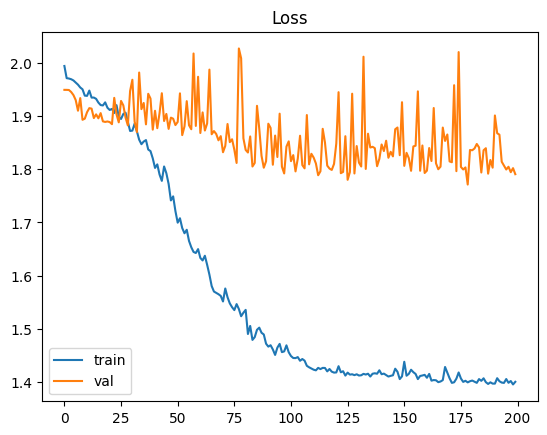

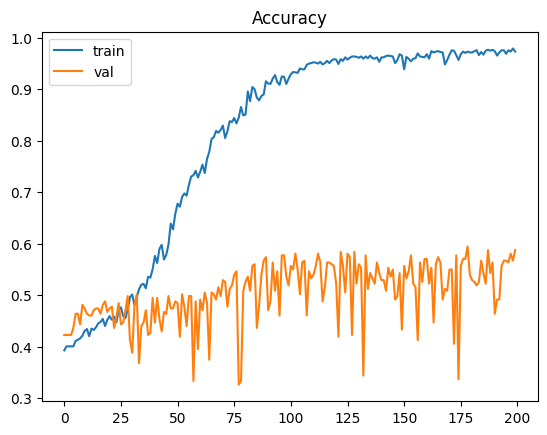

In [18]:
plt.figure(0)
plt.title('Loss')
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.show()

plt.figure(1)
plt.title('Accuracy')
plt.plot([acc.cpu().numpy() for acc in train_acc_history], label='train')
plt.plot([acc.cpu().numpy() for acc in val_acc_history], label='val')
plt.legend()
plt.show()


## Todo: Visualization with Grad-CAM on 3d fMRI